In [20]:
from argparse import Namespace
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [23]:
args = Namespace(
   img='../../../real-world-sample/healthy-0005.png',
   checkpoint= './mobilenetv3-05202025213410.pth',
)

In [24]:
NORMALIZE_MEAN = [0.485, 0.456, 0.406]
NORMALIZE_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE  = 224
CLASS_NAMES = [
    'algal_spot',
    'brown_blight',
    'gray_blight',
    'healthy',
    'helopeltis',
    'red-rust',
    'red-spider-infested',
    'red_spot',
    'white-spot'
]
NUM_CLASSES = len(CLASS_NAMES)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
predict_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE * 1.14)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),                      
    transforms.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
])

image = Image.open(args.img).convert("RGB")
input_tensor = predict_transform(image).unsqueeze(0).to(DEVICE)

In [27]:
model = models.mobilenet_v3_large(weights=None)

old_linear = model.classifier[3]
in_feats = old_linear.in_features
classifier = nn.Sequential(
     nn.Dropout(0.3),
     nn.Linear(in_features=in_feats, out_features=NUM_CLASSES),
)
model.classifier[3] = classifier

state = torch.load(args.checkpoint, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)

model.eval()

with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)
    top5_probs, top5_indices = torch.topk(probs, k=5, dim=1)

Top-5 Predictions:
1. healthy (98.04%)
2. helopeltis (1.49%)
3. red_spot (0.25%)
4. red-spider-infested (0.06%)
5. algal_spot (0.05%)


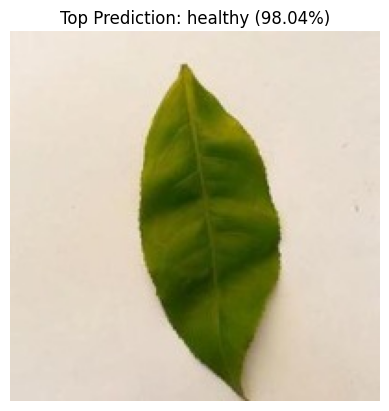

In [28]:
print("Top-5 Predictions:")
for i in range(5):
    class_idx = top5_indices[0][i].item()
    class_prob = top5_probs[0][i].item()
    print(f"{i+1}. {CLASS_NAMES[class_idx]} ({class_prob*100:.2f}%)")

plt.imshow(image)
plt.title(f"Top Prediction: {CLASS_NAMES[top5_indices[0][0].item()]} ({top5_probs[0][0].item()*100:.2f}%)")
plt.axis('off')
plt.show()
